In [1]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [3]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [4]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [5]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [6]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [7]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

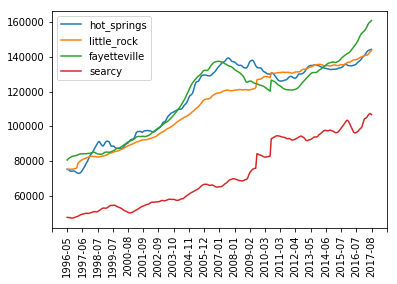

In [8]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [9]:
# remove rows with unemployment >= 3.5%
df = df[df.Unemployment < 3.5]

# remove rows with crime >= 3%
df = df[df.CrimeRatio < 0.03]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [10]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [11]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [12]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan)
df[date_columns] = df[date_columns].dropna()

In [13]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1992.196
Method:                       css-mle   S.D. of innovations           1006.221
Date:                Wed, 21 Nov 2018   AIC                           3998.391
Time:                        01:11:17   BIC                           4022.726
Sample:                    02-01-1997   HQIC                          4008.197
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1010.1910    484.735      2.084      0.038      60.127    1960.255
ar.L1.D.y      0.7894      0.065     12.235      0.000       0.663       0.916
ar.L2.D.y     -0.0996      0.082     -1.211      0.2

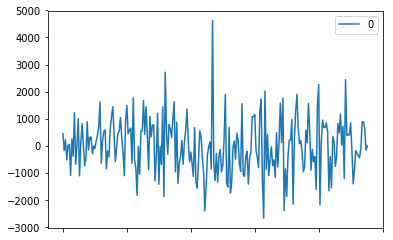

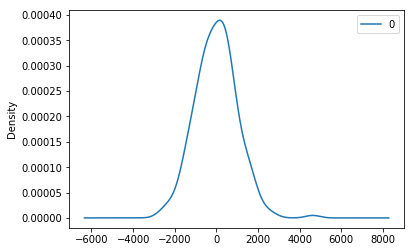

                 0
count   239.000000
mean     -2.069194
std    1008.618450
min   -2682.753851
25%    -675.706720
50%       9.156721
75%     595.122398
max    4625.965351


In [14]:
# plot residual errors
def residuals_plot(model_fit):
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # plot kernel density estimation
    residuals.plot(kind='kde')
    plt.show()

    # descriptibe statistics
    print(residuals.describe())

residuals_plot(model_fit)

NameError: name 'residuals' is not defined

In [15]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=388813.576701, expected=391050.000000
prediction difference: 0.005719

predicted=388813.576701

date: 2017-3
-----------------------------------------------
predicted=390443.689396, expected=392900.000000
prediction difference: 0.006252

predicted=390443.689396

date: 2017-4
-----------------------------------------------
predicted=392003.290988, expected=395800.000000
prediction difference: 0.009592

predicted=392003.290988

date: 2017-5
-----------------------------------------------
predicted=393503.316512, expected=398850.000000
prediction difference: 0.013405

predicted=393503.316512

date: 2017-6
-----------------------------------------------
predicted=394958.772728, expected=400850.000000
prediction difference: 0.014697

predicted=394958.772728

date: 2017-7
-----------------------------------------------
predicted=396374.708561, expected=402250.000000
prediction difference: 0.014606

predicted=396374.70856

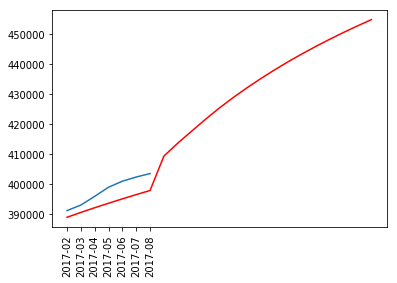

In [16]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(data)
    plt.plot(predictions, color='red')
    plt.xticks(rotation=90)
    plt.show()

rolling_plot(df_test, predictions)

In [24]:
# stationarity test
def difference(dataset, interval):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def compute_arima(
    data=df_train,
    p=5,
    q=0,
    d=0,
    delta=(12-len(df_test)) + 18,
    alpha=0.05,
    rplot=False,
    summary=False
):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in data]
    predictions = list()
    model_fit = False

    # generate model
    try:
        model = ARIMA(difference(history, delta), order=(p,q,d))
        model_fit = model.fit(disp=0)
        print('standard fit used')
    except Exception as e:
        print('stationary differences will be used')
        print('original error: {}'.format(e))

    # significant stationarity: use any that works
    if not model_fit:
        #
        # determine stationarity value: differencing handled with supplied data,
        #     as an indirect solution, since statsmodel not allow d > 2.
        #
        # @delta, autoregressive factor.
        #
        for delta in range(10):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('stationary fit: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use high (10) autoregression, since data is not
            #     seasonal. Therefore, using previous values is conservative.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(stationary, order=(p,q,d))
                    model_fit = model.fit(disp=0)
                    break
                except Exception as e:
                    print('bad condition {}: stationarity not adequate'.format(delta))
                    print('original error: {}'.format(e))
                    continue

    #
    # generate forecast: an inverse difference is needed to reverse the earlier
    #     difference model scaling.
    #
    if model_fit:
        output = model_fit.forecast(steps=delta, alpha=alpha)[0]
        if rplot:
            residuals_plot(model_fit)
        if summary:
            print(model_fit.summary())

    for yhat in output:
        inverted = inverse_difference(history, yhat, interval=delta)
        history.append(inverted)
        predictions.append(inverted)

    print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [18]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

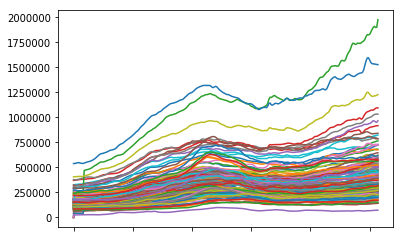

In [19]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [20]:
# iterate columns
results = []
for column in df_zipcode_clean.T[train_columns].T:
    predictions = compute_arima(df_zipcode_clean[column], q=1)
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

standard fit used
predictions: [344108.36931033386, 344353.95894948015, 344654.02597682487, 345894.4440390954, 346450.70963437425, 346108.7212172219, 347864.8430208451, 351619.69858650316, 354474.0004835777, 356128.18739288644, 357282.4089157267, 358236.67352587753, 359690.95764379937, 361445.2469523268, 363499.5359061505, 365853.8236435786, 368008.1106764886, 369662.3974935891, 371416.6842979367, 373770.9711346063, 377325.25799439364, 381179.5448629018, 383833.8317326611]
standard fit used
predictions: [238811.58648233418, 239986.8393176418, 241002.3345084355, 242320.4181024236, 243426.59739824352, 244624.1769218385, 246320.35778867514, 247815.824525328, 248411.2400166646, 249306.8148405293, 250202.48459366756, 250998.17912326643, 251993.8849227726, 253789.59157041536, 255885.29632423178, 258280.99998704463, 260376.7032556109, 261872.40635816252, 263468.10944579414, 264363.81255412503, 263759.5156754121, 263155.2188025568, 263250.92193205364]
standard fit used
predictions: [310045.459

standard fit used
predictions: [514577.24315474165, 518135.5481380518, 520458.2378707057, 522603.05928542564, 525037.9121527437, 526658.2226402956, 525177.5841822576, 524696.3328321635, 527314.9339808319, 531033.610060204, 534652.3476034345, 538871.0930906914, 543189.8430112478, 548008.5937699702, 554027.3441214141, 559846.0942083333, 564464.8442384416, 567983.5942403533, 572102.344237557, 576021.0942366221, 578139.8442368512, 578858.5942374482, 579177.3442382123]
standard fit used
predictions: [730281.1985355137, 733783.4571895333, 735216.2733062814, 736371.5228494967, 738935.00844193, 741811.5581618472, 745388.9214373872, 742366.8357564034, 735445.0505559013, 734223.4193577273, 740601.9041058702, 745080.4038188265, 747958.9117194958, 748737.4236892656, 751415.9377591066, 758394.4529466904, 766972.9683618922, 774151.4838897736, 779729.9994711356, 783108.5150785961, 785887.0306977244, 788765.5463200322, 791444.0619438281]
standard fit used
predictions: [728437.6031524879, 735690.000014

standard fit used
predictions: [441611.4242927188, 444196.39507551526, 445443.0104685168, 446035.90120619774, 446852.27989907877, 448578.7616281718, 449807.3555090303, 452037.16753231926, 454567.60078093834, 457198.295543669, 459729.08976548316, 462059.9194031565, 464890.7661424933, 467421.6204106598, 468552.47771444055, 469783.33622242685, 472414.1952248702, 475045.0544456185, 476975.91375778086, 478706.7731071404, 479937.63247179624, 482368.49184287986, 485399.3512166912]
standard fit used
predictions: [441733.00882589037, 441828.87599485926, 440379.63873222267, 439868.6644511555, 441076.8529406623, 442589.69210497366, 444204.04113920435, 447419.1667287318, 450434.61922582507, 453750.18009875074, 457865.7790200621, 461981.39388539473, 465897.01514963584, 469112.63874367514, 470528.26319594175, 471243.8879850256, 473259.5129056405, 476675.1378757359, 480190.76286444033, 482506.3878603049, 483722.0128589288, 485937.6378586017, 488553.26285867265]
standard fit used
predictions: [532192.

standard fit used
predictions: [648489.3010706005, 653912.0445124365, 658363.743421522, 661118.0865062597, 663759.96601296, 669401.1203436973, 675942.0463160079, 687082.9863106798, 699423.9938331655, 709465.0084583557, 716206.0247270988, 722647.0407965451, 727988.05648693, 735129.0721199915, 741870.0877416477, 748611.1033649172, 754752.1189903804, 758093.1346162681, 760934.1502422336, 766975.1658681883, 774016.1814941298, 778557.1971200684, 781298.2127460064]
standard fit used
predictions: [731011.2156261019, 735480.2126103898, 740506.6837946614, 745371.0806815334, 749368.121801781, 753114.9475105865, 758559.9192841306, 765303.1369542792, 771895.6686521333, 778088.4644256767, 785281.769920476, 791625.1026062685, 796518.4612771723, 803611.82997648, 813255.1952416678, 822598.5553796393, 830491.9151481653, 840735.2745560452, 851778.6338306356, 858921.9931460174, 862115.3525124001, 863658.7118835781, 864502.0712595303]
standard fit used
predictions: [1035615.5830689522, 1042937.0083572894,

standard fit used
predictions: [232744.10604933754, 234085.15433642475, 234696.39556995028, 235003.4904837256, 235686.72079078876, 236772.42451773156, 237769.65544476305, 238761.90117198502, 239554.7944939304, 240047.97365808097, 240940.932931643, 243433.82876700748, 246126.8311566603, 248019.7951778446, 249612.7611340453, 251905.73160316792, 254598.70076879274, 257091.6688200506, 259184.6378390962, 259877.60658556092, 258570.575303444, 257763.54406864257, 258156.512830668]
standard fit used
predictions: [241111.3786709584, 244798.692320716, 247627.27719588333, 249077.54060508992, 250341.8134577596, 251994.51397760888, 253450.1745353903, 254305.68050836743, 254661.1973505236, 255916.62902941348, 258272.1076081154, 260727.5756007918, 262683.044492058, 263738.51296391897, 263993.98187687114, 265649.45060149964, 268904.91936615173, 272460.38812497765, 275215.85688700364, 275771.3256469298, 275626.79440761555, 275782.2631681379, 275837.7319286961]
standard fit used
predictions: [424898.281

standard fit used
predictions: [171722.41834675908, 172859.73789391216, 173965.0355599587, 175481.01084833482, 177206.02380933936, 178691.36880589876, 180459.4510443586, 182011.00153280573, 182849.18409042116, 184079.47523479196, 185805.2847569455, 187327.8979748098, 188548.1818605233, 189866.96239648858, 191684.8013629154, 193102.00864888326, 194618.7813628472, 197435.26634418804, 199651.5643350779, 199767.7383055538, 199783.82892509337, 201299.86411924343, 202915.86278437075]
standard fit used
predictions: [207893.77608889385, 207011.27810044118, 206969.1926052542, 207273.43225662023, 208090.60873143244, 209303.86214961598, 210618.83256425406, 212134.11719107116, 214449.07744294842, 216363.91876609865, 217078.79605438313, 217393.648031079, 217908.49081243438, 218723.33468137824, 219938.17893721274, 221153.0224643212, 222367.86614349863, 224982.70990573164, 227997.5536548615, 229712.39740113128, 230627.2411570161, 230142.08491241938, 228856.92866727448]
standard fit used
predictions: 

standard fit used
predictions: [211482.8370514267, 212926.04224841422, 214574.02715877746, 215301.50025858576, 215810.64509334601, 216222.38480515938, 216634.00321114645, 217045.37357850472, 217856.67657292355, 219168.01134151474, 220179.3409783662, 221190.66889611067, 222701.99688588656, 225613.32508631272, 229124.6532138437, 232635.98133747673, 235647.30946457383, 238458.63759229437, 239769.9657193659, 239981.29384651277, 240992.62197368662, 244203.9501008562, 247415.278228022]
standard fit used
predictions: [244507.42957995625, 245662.50255609, 245600.5684581447, 246111.80463083365, 248539.64867812255, 250828.4421669418, 251813.06339801374, 251993.69785167417, 252672.34350729603, 254351.0971540451, 256730.81921306445, 259010.75426536947, 260390.83757347157, 261670.9698406565, 263551.0875309482, 265231.1787026927, 266811.2609662082, 269191.3382825889, 272371.4144838038, 275551.49136607506, 278731.5690434353, 281111.6470565822, 282891.72522568563]
standard fit used
predictions: [41012

standard fit used
predictions: [224962.62784690407, 224868.40201259535, 225826.67231587702, 225925.90527284882, 224465.05876452036, 224029.1124355108, 224607.91027154654, 226089.5427393098, 227172.7498914733, 226657.080611298, 224341.68830399273, 225026.34102418492, 229511.07650720203, 235095.83589999133, 239280.59498781248, 243365.35803999906, 246450.12366140503, 249234.88898767863, 252319.6544005531, 252104.42003471102, 248289.18566026195, 245673.9512663922, 245058.71689039547]
standard fit used
predictions: [174682.81524006373, 174572.04076258477, 174730.98163846455, 174581.90896880292, 173724.40650742917, 173670.42818612154, 174214.9949387916, 175158.37351522854, 175101.78281592682, 173545.21409917588, 171788.55323436167, 172731.90064842952, 175975.26073296086, 179918.61858721313, 183761.97642034097, 186905.33583611195, 188248.69524476395, 189392.05455061147, 190935.41393354803, 191078.77332528104, 189822.1326970265, 189265.49207001645, 189308.85144419278]
standard fit used
predict

In [37]:
## local variables
agg = []

# sum difference squared
for zipcode in results:
    z = zipcode['zip_code']
    actual = df_zipcode_clean.T[test_columns].T[z]
    print(actual)
    predicted = zipcode['predictions']
    print('=================================================')
    print(z)
    print('=================================================')

    # compare differences
    sum = 0
    for act, pred in zip(actual, predicted[:len(test_columns)]):
        sum += sqrt((act - pred)**2)
        print('predicted={:03f}, expected={:03f}'.format(float(pred), act))
        print('prediction difference: {:03f}'.format(abs(1-float(pred)/act)))
        print('-------------------------------------------------')

    print('\n')

    # aggregate data
    agg.append({
        'zipcode': zipcode['zip_code'],
        'difference': sum,
        'predicted': predicted
    })

# sort results: allows the n lowest to be collected
sorted_results = sorted(agg, key=lambda x: (x['difference']))

2017-02    330300.0
2017-03    331700.0
2017-04    332600.0
2017-05    333600.0
2017-06    335200.0
2017-07    338000.0
2017-08    341100.0
Name: 01002, dtype: float64
01002
predicted=344108.369310, expected=330300.000000
prediction difference: 0.041806
-------------------------------------------------
predicted=344353.958949, expected=331700.000000
prediction difference: 0.038149
-------------------------------------------------
predicted=344654.025977, expected=332600.000000
prediction difference: 0.036242
-------------------------------------------------
predicted=345894.444039, expected=333600.000000
prediction difference: 0.036854
-------------------------------------------------
predicted=346450.709634, expected=335200.000000
prediction difference: 0.033564
-------------------------------------------------
predicted=346108.721217, expected=338000.000000
prediction difference: 0.023990
-------------------------------------------------
predicted=347864.843021, expected=341100.00000

-------------------------------------------------
predicted=420774.034014, expected=403900.000000
prediction difference: 0.041778
-------------------------------------------------
predicted=423967.099578, expected=406300.000000
prediction difference: 0.043483
-------------------------------------------------
predicted=428560.752272, expected=407600.000000
prediction difference: 0.051425
-------------------------------------------------


2017-02    510300.0
2017-03    514300.0
2017-04    518700.0
2017-05    522400.0
2017-06    524500.0
2017-07    525000.0
2017-08    525000.0
Name: 01880, dtype: float64
01880
predicted=529744.941509, expected=510300.000000
prediction difference: 0.038105
-------------------------------------------------
predicted=536445.305522, expected=514300.000000
prediction difference: 0.043059
-------------------------------------------------
predicted=543383.731426, expected=518700.000000
prediction difference: 0.047588
--------------------------------------------

-------------------------------------------------
predicted=650467.283400, expected=616000.000000
prediction difference: 0.055953
-------------------------------------------------


2017-02    363200.0
2017-03    364950.0
2017-04    367300.0
2017-05    369800.0
2017-06    370850.0
2017-07    370650.0
2017-08    370850.0
Name: 02188, dtype: float64
02188
predicted=371979.176981, expected=363200.000000
prediction difference: 0.024172
-------------------------------------------------
predicted=372904.366470, expected=364950.000000
prediction difference: 0.021796
-------------------------------------------------
predicted=374571.041504, expected=367300.000000
prediction difference: 0.019796
-------------------------------------------------
predicted=376370.866697, expected=369800.000000
prediction difference: 0.017769
-------------------------------------------------
predicted=378084.347743, expected=370850.000000
prediction difference: 0.019507
--------------------------------------------

Name: 03046, dtype: float64
03046
predicted=286265.261305, expected=279400.000000
prediction difference: 0.024571
-------------------------------------------------
predicted=288742.443036, expected=282200.000000
prediction difference: 0.023184
-------------------------------------------------
predicted=289439.641942, expected=283600.000000
prediction difference: 0.020591
-------------------------------------------------
predicted=291225.887089, expected=284800.000000
prediction difference: 0.022563
-------------------------------------------------
predicted=295046.706861, expected=285200.000000
prediction difference: 0.034526
-------------------------------------------------
predicted=298278.343032, expected=284100.000000
prediction difference: 0.049906
-------------------------------------------------
predicted=300215.787776, expected=282900.000000
prediction difference: 0.061208
-------------------------------------------------


2017-02    468800.0
2017-03    467800.0
2017-04    466

-------------------------------------------------
predicted=194195.210215, expected=194000.000000
prediction difference: 0.001006
-------------------------------------------------
predicted=195776.954992, expected=193000.000000
prediction difference: 0.014388
-------------------------------------------------
predicted=196188.338211, expected=193400.000000
prediction difference: 0.014417
-------------------------------------------------
predicted=196288.441426, expected=194000.000000
prediction difference: 0.011796
-------------------------------------------------
predicted=198652.785645, expected=194000.000000
prediction difference: 0.023983
-------------------------------------------------
predicted=200235.853048, expected=193700.000000
prediction difference: 0.033742
-------------------------------------------------


2017-02    307300.0
2017-03    310400.0
2017-04    312000.0
2017-05    311900.0
2017-06    312000.0
2017-07    313700.0
2017-08    315800.0
Name: 03290, dtype: float64


prediction difference: 0.040639
-------------------------------------------------
predicted=287230.940608, expected=274900.000000
prediction difference: 0.044856
-------------------------------------------------


2017-02    260300.0
2017-03    261800.0
2017-04    262800.0
2017-05    263300.0
2017-06    263800.0
2017-07    265200.0
2017-08    267800.0
Name: 03884, dtype: float64
03884
predicted=272567.710609, expected=260300.000000
prediction difference: 0.047129
-------------------------------------------------
predicted=273529.458070, expected=261800.000000
prediction difference: 0.044803
-------------------------------------------------
predicted=273199.413891, expected=262800.000000
prediction difference: 0.039572
-------------------------------------------------
predicted=273771.853919, expected=263300.000000
prediction difference: 0.039772
-------------------------------------------------
predicted=275839.627154, expected=263800.000000
prediction difference: 0.045639
------------

2017-02    221000.0
2017-03    221800.0
2017-04    222600.0
2017-05    222900.0
2017-06    224400.0
2017-07    226800.0
2017-08    229100.0
Name: 22655, dtype: float64
22655
predicted=232146.473612, expected=221000.000000
prediction difference: 0.050437
-------------------------------------------------
predicted=233049.915627, expected=221800.000000
prediction difference: 0.050721
-------------------------------------------------
predicted=234003.032222, expected=222600.000000
prediction difference: 0.051227
-------------------------------------------------
predicted=235143.094601, expected=222900.000000
prediction difference: 0.054926
-------------------------------------------------
predicted=235111.894940, expected=224400.000000
prediction difference: 0.047736
-------------------------------------------------
predicted=233824.775712, expected=226800.000000
prediction difference: 0.030973
-------------------------------------------------
predicted=232831.155105, expected=229100.00000

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

standard fit used


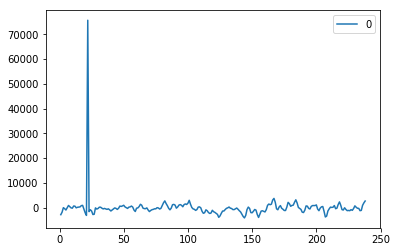

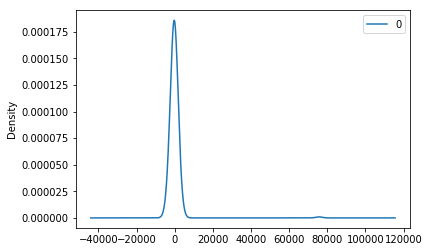

                  0
count    238.000000
mean       1.617714
std     5105.194642
min    -4135.697647
25%    -1067.009252
50%     -282.738108
75%      507.400747
max    75655.153140
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  238
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2369.261
Method:                       css-mle   S.D. of innovations           5094.435
Date:                Wed, 21 Nov 2018   AIC                           4752.522
Time:                        01:33:07   BIC                           4776.828
Sample:                             1   HQIC                          4762.318
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        327.6580    387.5

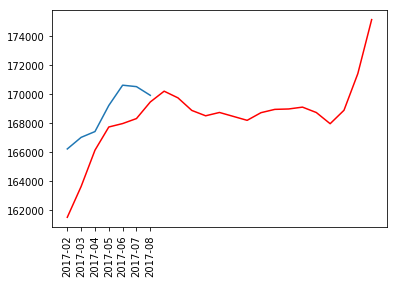

standard fit used


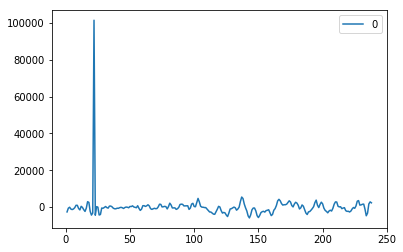

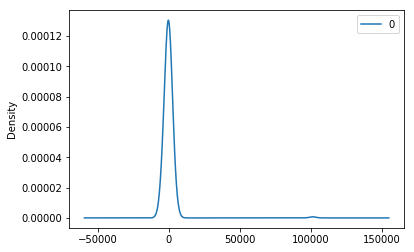

                   0
count     238.000000
mean        1.283734
std      6910.183123
min     -5897.244315
25%     -1648.675461
50%      -362.988139
75%       725.988242
max    101429.938657
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  238
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2441.313
Method:                       css-mle   S.D. of innovations           6895.637
Date:                Wed, 21 Nov 2018   AIC                           4896.626
Time:                        01:33:08   BIC                           4920.932
Sample:                             1   HQIC                          4906.422
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        443.2773

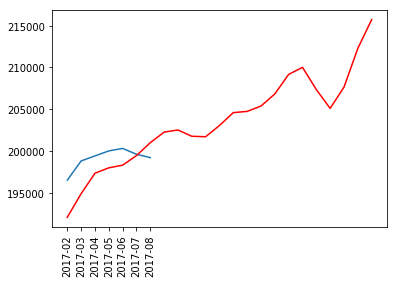

standard fit used


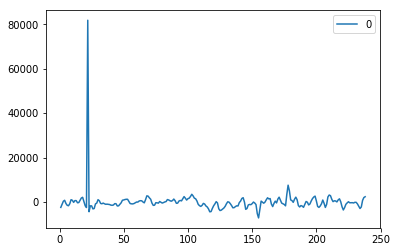

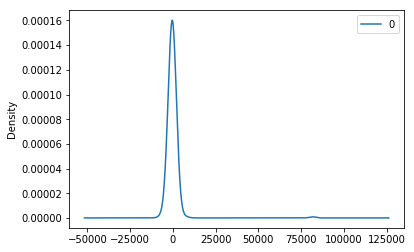

                  0
count    238.000000
mean       1.916776
std     5606.425888
min    -7181.262268
25%    -1409.890633
50%     -370.895530
75%      740.957071
max    81821.659317
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  238
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2391.553
Method:                       css-mle   S.D. of innovations           5594.612
Date:                Wed, 21 Nov 2018   AIC                           4797.105
Time:                        01:33:10   BIC                           4821.411
Sample:                             1   HQIC                          4806.901
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        347.8992    445.6

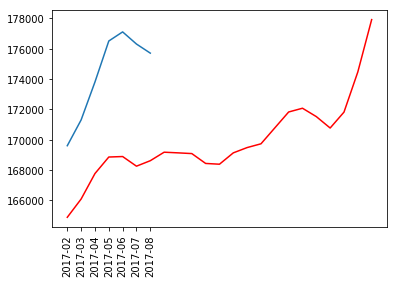

standard fit used


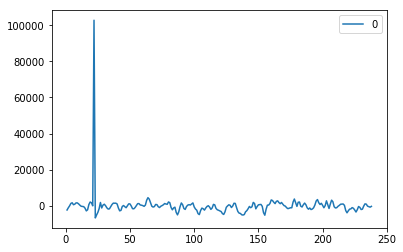

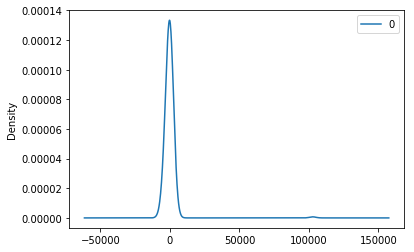

                   0
count     238.000000
mean       -0.698319
std      6954.788693
min     -6723.138345
25%     -1551.996635
50%      -305.872944
75%       900.762272
max    102726.143019
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  238
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2442.852
Method:                       css-mle   S.D. of innovations           6940.125
Date:                Wed, 21 Nov 2018   AIC                           4899.705
Time:                        01:33:11   BIC                           4924.010
Sample:                             1   HQIC                          4909.500
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        439.9160

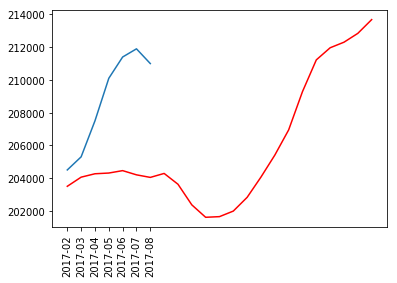

In [25]:
# best 4 models
for model in sorted_results[:4]:
    # get data
    zipcode = model['zipcode']
    data_zipcode = df_zipcode_clean[[zipcode]]
    data_train = data_zipcode.T[train_columns].T
    
    # compute_arima
    predictions = compute_arima(
        data_train.iloc[:,0],
        q=1,
        rplot=True,
        summary=True
    )

    # plot predictions
    rolling_plot(data_zipcode.T[test_columns].T, predictions)

In [36]:
print(sorted_results)

[{'zipcode': '24441', 'difference': 11847.980206093023, 'predicted': [168447.30117790433, 168039.8229026975, 168273.76583592084, 168010.56245075286, 167738.78434177118, 168267.6535542994, 168495.9093636062, 168523.66081445204, 168651.35546627655, 168279.09136225889, 167506.8148237858, 168434.54355833138, 170962.27714662085, 174690.0114422224, 178417.74569184176, 181245.48014028338, 182373.2145622708, 183100.9489471821, 185228.68332630198, 186956.41770362726, 187184.15207840837, 186911.8864531362, 186739.62082806343]}, {'zipcode': '22821', 'difference': 12844.825921127805, 'predicted': [198827.60002151062, 198677.87487810015, 199964.4419335587, 201476.82119079624, 201596.9923184801, 202217.43861774864, 203639.40671713365, 205962.23455706943, 206785.4175242613, 204108.72655016574, 201832.0970213296, 204355.5040513846, 208978.9278164167, 212402.35880968045, 215625.79314225583, 219249.22914070828, 221972.66594613763, 222996.10312137645, 224019.54046850122, 224742.97789774142, 224466.415366